# Kmer latent space autoencoder

In [5]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import manifold,neighbors
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

In [6]:
X=pd.read_pickle("../data/kls.pkl")

### Pytorch implemenation

In [44]:
#export
from fastai import *
from fastai.basic_data import *
from fastai.basic_train import *
from fastai.tabular import *
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

class KlsDataset(Dataset):
    """Kmer latent representation dataset"""
    def __init__(self, data,noise=0.):
        super().__init__()
        self.items = data.values if isinstance(data, pd.DataFrame) else data
        self.noise = noise
        
    def __len__(self):
        return len(self.items)
    def __getitem__(self, idx):
        item = self.items[idx,:]
        return (item if self.noise == 0. else self.mix_noise(item), item)
    
def wing(dims):
    layer_dims = list(zip(dims[:-1],dims[1:]))
    fcl = [nn.Linear(*x, bias=False) for x in layer_dims]
    relu = [nn.ReLU() for _ in range(len(fcl))]
    layers = np.asarray(list(zip(fcl, relu))).ravel()[:-1]                                
    return nn.Sequential(*layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


def print_weights(nlayer):
    print(list(net.encoder.modules())[nlayer].weight)

class KlsAutoEncoder (nn.Module):
    """Generic autoencoder"""
    def __init__(self, encoder_dims, decoder_dims):
        super().__init__(self)
        self.encoder = wing(encoder_dims)
        self.decoder = wing(decoder_dims)
         
    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)
    
    def save_encoder(self,file:PathOrStr):
        torch.save(self.encoder.state_dict(), path)

class Encoder():
    """Encoder part of KlsAutoeEncoder ready for inference"""   

#     def __init__(cls,file:PathOrStr,e_dims:Collection=[100,50,3], d_dims:Collection=[3,50,100]):
#         m = KlsAutoEncoder(e_dims,d_dims).double()
#         e = m.encoder
#         e.load_state_dict(torch.load(file))
#         e.eval()
#         self.e = e

    def __init__(self,file:PathOrStr,dims:Collection=[100,50,3]):
        e = wing(dims).double()
        e.load_state_dict(torch.load(file))
        e.eval()
        self.e = e
       
    def encode(self,data:Collection):
        """transform ```data``` to latent representaion"""
        return self.e.forward(tensor(data).double()).cpu().detach().numpy()

In [45]:
!python notebook2script.py "KlsAutoencoder.ipynb"

../exp/nb_KlsAutoencoder.py
Converted KlsAutoencoder.ipynb to ../exp/nb_KlsAutoencoder.py


In [8]:
encoder_dims = [100,50,3]
decoder_dims = [3,50,100]

net = KlsAutoEncoder(encoder_dims,decoder_dims).double()

In [212]:
net.encoder.apply(init_weights)
net.decoder.apply(init_weights)
net.opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

nepoch = 70
for epoch in range(nepoch):
    idata = iter(list(X.values()))
    print (f"Epoch {epoch}", end =" ")
    for i, vec in enumerate(idata):
        invec = tensor(vec)
        loss = F.mse_loss(model.forward(invec), invec)
        loss.backward()
        opt.step()
        opt.zero_grad()
    print(f"loss:{loss:.5f}") 

### Fast.ai implementation

In [9]:
encoder_dims = [100,50,3]
decoder_dims = [3,50,100]

model = KlsAutoEncoder(encoder_dims,decoder_dims).double()

train, valid = train_test_split(X, train_size=0.9) 
db = DataBunch.create(KlsDataset(train),KlsDataset(valid))

learn = Learner(db, model)
learn.loss_func = F.mse_loss

/home/serge/anaconda3/envs/bio-2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


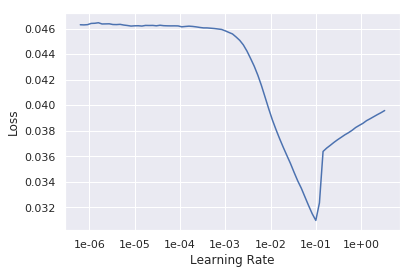

In [5]:
learn.lr_find();learn.recorder.plot()

In [6]:
learn.fit(10, lr=5e-2)

epoch,train_loss,valid_loss,time
0,0.008540,0.002037,00:00
1,0.003453,0.001928,00:00
2,0.002372,0.001907,00:01
3,0.002099,0.001953,00:01
4,0.002085,0.001869,00:00
5,0.002009,0.001949,00:00
6,0.001935,0.001834,00:00
7,0.001865,0.001726,00:00
8,0.001848,0.001869,00:01
9,0.001867,0.001815,00:01


In [7]:
learn.fit(10, lr=1e-2)

epoch,train_loss,valid_loss,time
0,0.001644,0.001572,00:01
1,0.001610,0.001568,00:00
2,0.001607,0.001566,00:00
3,0.001631,0.001569,00:00
4,0.001628,0.001572,00:00
5,0.001632,0.001591,00:00
6,0.001619,0.001564,00:00
7,0.001623,0.001574,00:00
8,0.001602,0.001597,00:00
9,0.001597,0.001564,00:01


### Visualising reduced latent space

In [11]:
encoder = model.encoder.eval().cpu()

In [39]:
d = encoder.forward(tensor(X.values))
d = MinMaxScaler().fit_transform(d)

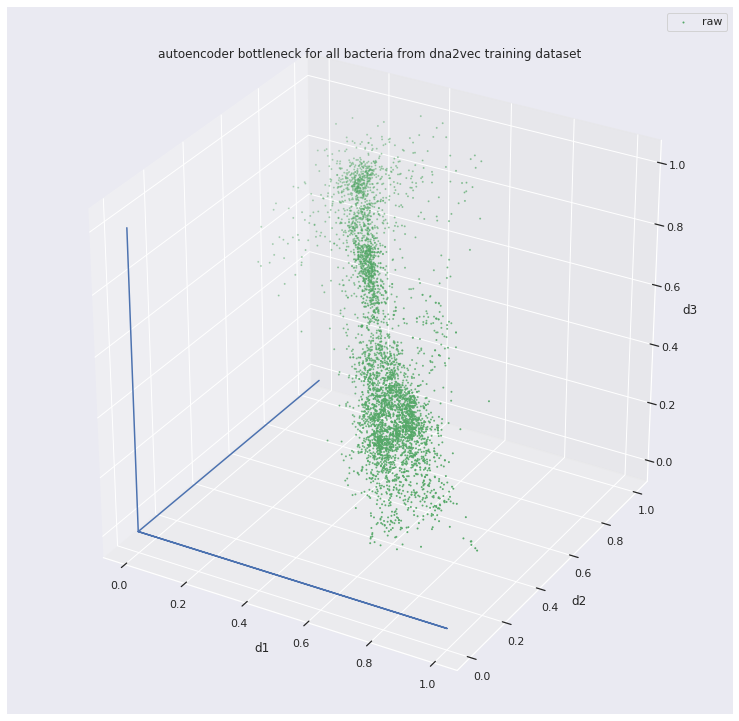

In [44]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(d[:,1],d[:,2],d[:,2], marker="o",s=1,color='g', label = "raw")
ax.plot((0.,0.,0.),(1.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,1.,0.),(0.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,0.,0.),(0.,0.,0.), (0.,0.,1.), color = "b")
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')
ax.set_title("autoencoder bottleneck for all bacteria from dna2vec training dataset")
plt.legend()
plt.show()

### Denoised data

In [21]:
Xdn =pd.read_pickle("../data/kls_denoised.pkl")

In [22]:
d = encoder.forward(tensor(Xdn.values))

In [26]:
d = MinMaxScaler().fit_transform(d)

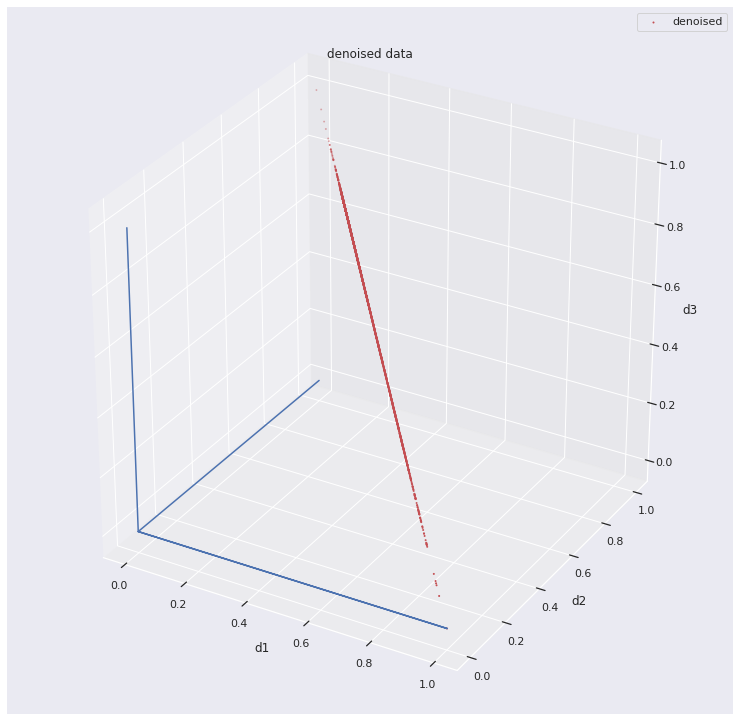

In [28]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(d[:,1],d[:,2],d[:,2], marker="o",s=1,color='r', label = "denoised")
ax.plot((0.,0.,0.),(1.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,1.,0.),(0.,0.,0.),(0.,0.,0.), color = "b")
ax.plot((0.,0.,0.),(0.,0.,0.), (0.,0.,1.), color = "b")
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')
ax.set_title("denoised data")
plt.legend()
plt.show()

### Saving Autoencoder model

In [ ]:
torch.save(encoder.state_dict(), "../data/models/klm-encoder-3d") 

In [21]:
e = load_encoder("../data/models/klm-encoder-3d")

In [14]:
d = e.forward(tensor(Xdn.values))

NameError: name 'Xdn' is not defined

In [38]:
d

tensor([[ 79420.7078, 168541.9572, -89049.2685],
        [ 82330.3503, 174716.2698, -92311.8225],
        [ 80071.9756, 169924.3589, -89779.3570],
        ...,
        [ 79644.1878, 169016.2192, -89299.8329],
        [ 79839.3627, 169430.8322, -89518.5970],
        [ 79832.3720, 169415.8684, -89510.7742]], dtype=torch.float64,
       grad_fn=<MmBackward>)